In [39]:
#!pip install pandas-datareader

In [40]:
import pandas as pd

In [41]:
from datetime import datetime

In [42]:
btc = pd.read_csv("BTC-USD.csv")
btc = btc.set_index(pd.to_datetime(btc["Date"]))
btc = btc.loc[datetime(2018,1,1):datetime(2020,12,2)]
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2018-01-01,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
sns.set()

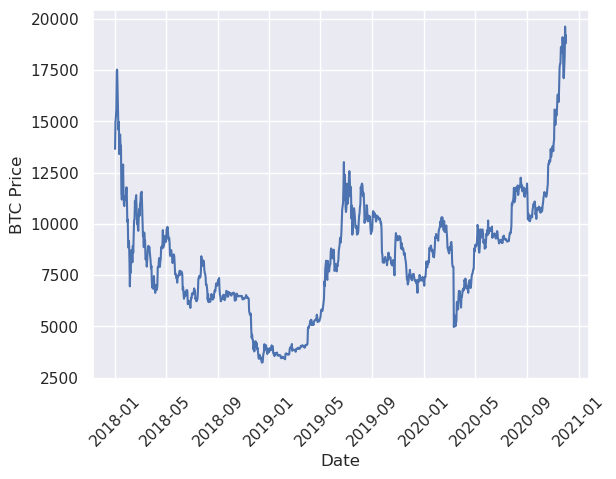

In [45]:
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc['Close'])

In [46]:
train = btc[btc.index < pd.to_datetime("2020-11-01", format='%Y-%m-%d')]
test = btc[btc.index > pd.to_datetime("2020-11-01", format='%Y-%m-%d')]

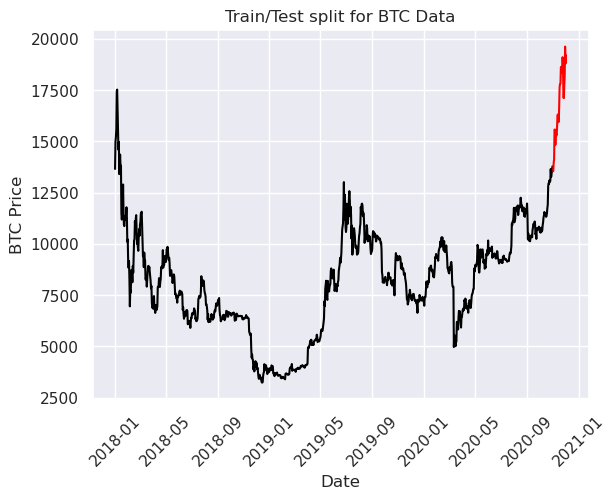

In [47]:
plt.plot(train["Close"], color = "black")
plt.plot(test["Close"], color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

In [48]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [49]:
from pmdarima.arima import auto_arima

In [53]:
autoARIMA = auto_arima(train["Close"], seasonal=True, m=12)
autoARIMA.fit(train["Close"])
autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1035
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7501.923
Date:                Sat, 25 May 2024   AIC                          15005.847
Time:                        04:34:04   BIC                          15010.788
Sample:                    01-01-2018   HQIC                         15007.722
                         - 10-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.172e+05   2022.830     57.939      0.000    1.13e+05    1.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.87   Jarque-Bera (JB):              5368.38
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

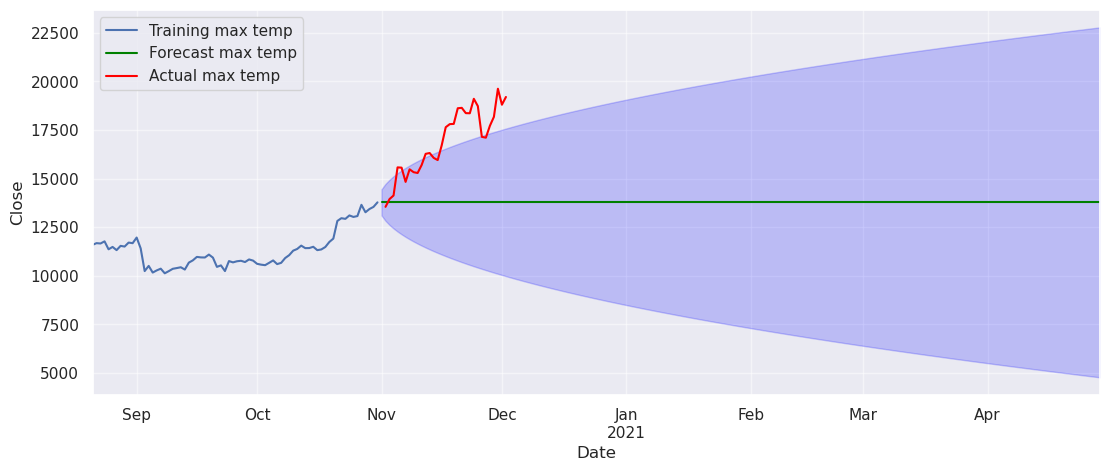

In [54]:
# Make predictions
forecast_auto, conf_int_auto = autoARIMA.predict(n_periods=180, return_conf_int=True)

# Get forecast and confidence intervals for two years
forecast_values_auto = forecast_auto
confidence_intervals_auto = conf_int_auto

# Plot forecast with training data
ax = train["Close"][-12*6:].plot(figsize=(13,5))
forecast_auto.plot(ax=ax, color="green")
test["Close"].plot(ax=ax, color="Red")
plt.fill_between(forecast_values_auto.index, 
    confidence_intervals_auto[:,[0]].flatten(), confidence_intervals_auto[:,[1]].flatten(), 
    color='blue', alpha=0.2
)
plt.legend(['Training max temp', 'Forecast max temp', 'Actual max temp'], loc='upper left')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(alpha=0.5)
plt.show()

In [52]:
np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))

NameError: name 'y_pred_df' is not defined

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
#%%capture --no-stdout
### Import Packages ###

import itertools
from itertools import product
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
import math
import pickle

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = [*itertools.product(p, d, q)]

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 12) for x in pdq]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function

import pickle

def sarimax_gridsearch(ts, pdq, pdqs, maxiter=None, freq='D'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    #ans = []
    ans_dict = dict()
    try:
        with open("ans_dict.pkl", "rb") as pkl:
            ans_dict = pickle.load(pkl)
    except FileNotFoundError:
        pass
    except EOFError:
        pass

    for comb in tqdm(pdq):
        for combs in tqdm(pdqs,leave=0):
            #model_file = f"SARIMAX/gridSearch_{comb}-X-{combs}.pkl"
            key = (comb, combs)
            
            try:
                if key in ans_dict:
                    continue
                mod = sm.tsa.statespace.SARIMAX(ts, order=comb, seasonal_order=combs, 
                    enforce_stationarity=False, enforce_invertibility=False, freq=freq,
                ).fit(disp=0) 
                metric = mod.bic
                #ans.append([comb, combs, mod.bic])
                ans_dict[key] = metric
                with open("ans_dict.pkl", "wb") as pkl:
                    pickle.dump(ans_dict, pkl)
                
                # TODO 1 Retain metrics so that evaluated models won't need to be reloaded
                if mod.bic in [float("inf"), float("-inf")] or math.isnan(mod.bic):
                    continue
                #print('SARIMAX {} x {} 12 : AIC Calculated = {}'.format(comb, combs, output.bic))
            except BaseException as error:
                if any(isinstance(error, kind) for kind in []):
                    continue
                else:
                    raise
            
    # Find the parameters with minimal BIC value

    ans = [(*k,v) for k,v in ans_dict.items()]
    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:len(ans_df)//10]
    
    return ans_df
    
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
data = btc["Close"]#.resample("W").mean()
best_hyperparams = sarimax_gridsearch(data, pdq, pdqs, freq="D", maxiter=50)
best_hyperparams

In [ ]:
def compare_best_rmse(data, hyperparameters):
    rmse = float("inf")
    for _, hyperparams in hyperparameters.iterrows():
        try:
            mod = sm.tsa.statespace.SARIMAX(data, order=hyperparams.pdq, seasonal_order=hyperparams.pdqs,
                enforce_stationarity=False, enforce_invertibility=False, #freq="M",
            )\
            .fit(disp=0)

            y_pred = mod.get_forecast(len(test.index))
            y_pred_df = y_pred.conf_int(alpha=0.05) 
            y_pred_df["Predictions"] = mod.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
            y_pred_df.index = test.index
            y_pred_out = y_pred_df["Predictions"] 

            _rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
            if _rmse < rmse:
                print(f"Found better model: hyperparameters = {hyperparams.pdq} X {hyperparams.pdqs} - RMSE = {_rmse}")
                best_mod = mod
                rmse = _rmse
        except:
            raise
                
    return mod

bestARIMA = compare_best_rmse(data, best_hyperparams)
bestARIMA.summary()

In [ ]:
# Make predictions
y_pred = bestARIMA.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]
conf_int_auto = y_pred_df

# Get forecast and confidence intervals for two years
forecast_values_auto = forecast_auto
confidence_intervals_auto = conf_int_auto

# Plot forecast with training data
#ax = train.plot(figsize=(13,5))
ax = train["Close"][-12*6:].plot(figsize=(13,5))
forecast_auto.plot(ax=ax, color="green")
test["Close"].plot(ax=ax, color="Red")
plt.fill_between(test.index, 
    confidence_intervals_auto["lower Close"], confidence_intervals_auto["upper Close"], 
    color='blue', alpha=0.2
)
plt.legend(['Training max temp', 'Forecast max temp', 'Actual max temp'], loc='upper left')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(alpha=0.5)
plt.show()

In [ ]:
btc = pd.read_csv("BTC-USD.csv")
btc = btc.set_index(pd.to_datetime(btc["Date"]))
#btc = btc.loc[datetime(2018,1,1):datetime(2020,12,2)]
btc

In [ ]:
def timeseries_train_test_split(timeseries, cutoff):
    train = timeseries.loc[:cutoff]
    test = timeseries.loc[cutoff:]
    return train, test

In [ ]:
cutoff = datetime(2023,1,1)
train,test = timeseries_train_test_split(btc, cutoff)
test

In [ ]:
def fit_moving_average(data, period, period_len,):
    # Of the moving avg, the last period_len elements are None, so they're dropped.
    ma = data.resample(period).mean(numeric_only=True).rolling(period_len).mean(numeric_only=True)[period_len:]
    return ma

In [ ]:
period = "M"
period_len = 12
ma = fit_moving_average(btc, period, period_len)

In [ ]:
predictions = ma.loc[cutoff:]
predictions

In [ ]:
np.sqrt(mean_squared_error(test["Close"].resample("M").mean(), predictions["Close"]))

In [ ]:
#ax = plt.axes()
plt.plot(train["Close"], color="black")
plt.plot(test["Close"], color="red")
plt.plot(predictions["Close"], color="green")